In [1]:
## plot within the notebook
%matplotlib inline
import warnings
import numpy as np
## No annoying warnings
warnings.filterwarnings('ignore')

In [2]:
from astrobject.utils.plot.skybins import SurveyFieldBins
ztf_fields = np.genfromtxt('data/ZTF_Fields.txt', comments='%')
bins = SurveyFieldBins(ra=ztf_fields[:,1], dec=ztf_fields[:,2])
# Fields are defined by their midpoints
# Default width and height are set to 7 degrees for now
# There is more field overlap the closer you get to the poles (no surprise)

In [76]:
# Make a mock survey plan (by no means realistic, just trying to capture the effect of
# moving the observed part of the sky along according to the seasons)
import astrobject.simulation as simul
obs_days = np.arange(58000, 58181, 1)

dec_range = [-20, 60]
ra_range = [0, 90]
ra_shift = 360. / 365.25

t_obs = 60.
t_night = 8. * 3600

obs = {'time': [], 'field': [], 'band': [], 'skynoise': []}
for d in obs_days:
    # Find fields that have their center within dec_range and in ra_range shifted by ra_shift for each day
    field_idx = np.where((bins.ra > ra_range[0] + ra_shift * (d - obs_days[0])) &
                         (bins.ra < ra_range[1] + ra_shift * (d - obs_days[0])) &
                         (bins.dec > dec_range[0]) & (bins.dec < dec_range[1]))[0]
    
    # Sort first by ra then by dec
    field_idx = field_idx[np.argsort(bins.ra[field_idx])]
    field_idx = field_idx[np.argsort(bins.dec[field_idx])]

    for k, t in enumerate(np.arange(0, t_night, t_obs)):
        obs['time'].append(d + t / 86400.)
        obs['field'].append(field_idx[k % len(field_idx)])
        obs['band'].append(['desr', 'desg'][(k / len(field_idx)) % 2])
        obs['skynoise'].append(150.) # TBD later, completely random number for now
        
plan = simul.SurveyPlan(time=obs['time'], band=obs['band'], obs_field=obs['field'],
                        skynoise=obs['skynoise'],
                        fields=dict(ra=ztf_fields[:,1], dec=ztf_fields[:,2]))

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7f43872b7e90>,
 'cbar': <matplotlib.colorbar.ColorbarBase at 0x7f437cce02d0>,
 'collection': <matplotlib.collections.PolyCollection at 0x7f437bf37350>,
 'figure': <matplotlib.figure.Figure at 0x7f437b369d10>}

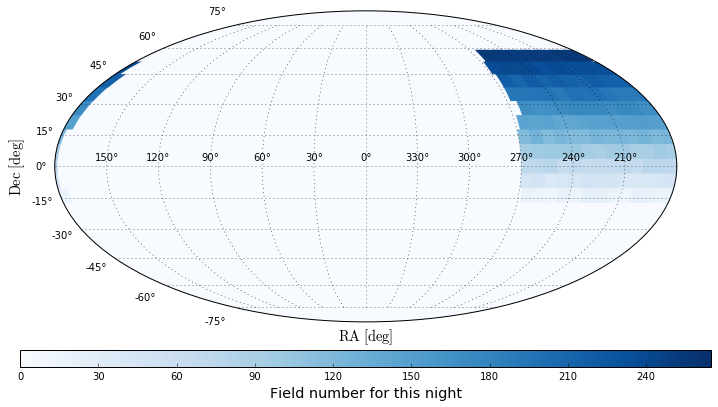

In [77]:
# Example of selected fields (last of the nights in the mock survey)
# The fields are number by the order in which they are observed.
vals = np.zeros(bins.nbins)
for k,l in enumerate(field_idx):
    vals[l] = k
    
bins.imshow(vals, cblabel="Field number for this night")

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7f438cbd7190>,
 'cbar': <matplotlib.colorbar.ColorbarBase at 0x7f437fce14d0>,
 'collection': <matplotlib.collections.PolyCollection at 0x7f4387241e10>,
 'figure': <matplotlib.figure.Figure at 0x7f437b369d50>}

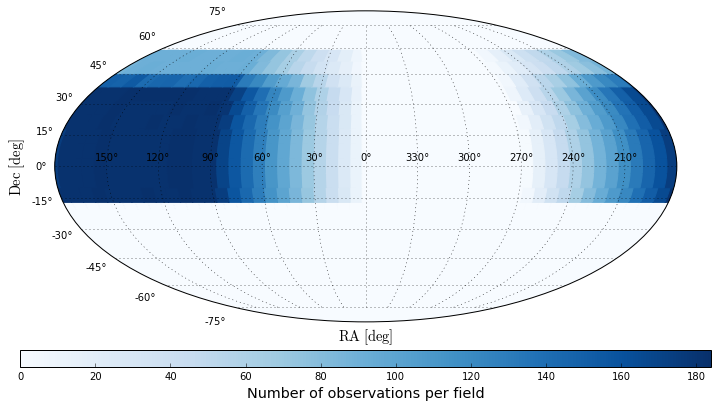

In [78]:
# Number of pointings per field
vals, _ = np.histogram(obs['field'], bins=range(bins.nbins + 1))
bins.imshow(vals, cblabel="Number of observations per field")

In [79]:
tr = simul.sn_generator([0.01,0.1], ratekind="basic", 
                        mjd_range=[obs_days[0] - 60, obs_days[-1] + 25])
# ratekind is the rate of the transient: basiclow = 1e3 
# -> comoving volumetric rate at each redshift in units of yr^-1 Mpc^-3.
# type_ is the type of transient. 
# This will parse the ratekind+type_ do get the good rate function

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7f437fcd8790>,
 'cbar': <matplotlib.colorbar.ColorbarBase at 0x7f437a9af450>,
 'collection': <matplotlib.collections.PolyCollection at 0x7f437fd1ad90>,
 'figure': <matplotlib.figure.Figure at 0x7f437b369810>}

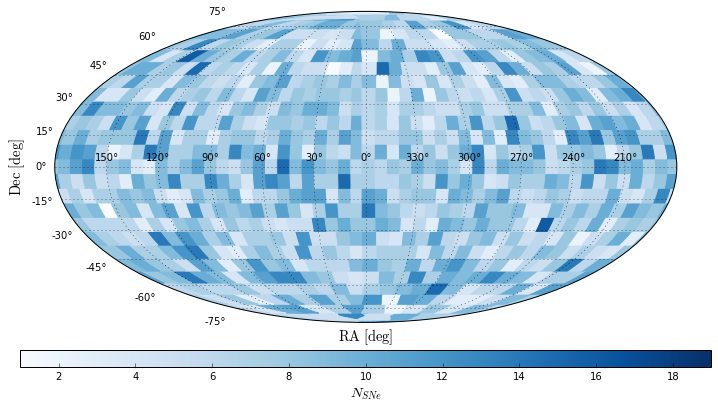

In [80]:
tr.hist_skycoverage(bins=bins)
# Since the fields can overlap, some SNe will be counted twice
# Overlapping fields partly obscure previously drawn 
# Some distortions when drawing fields near the poles (to be fixed later)

SNe observed: 1549 out of 6295


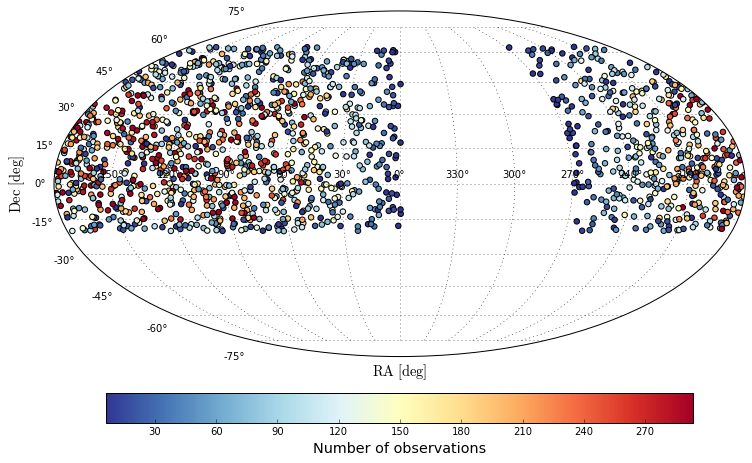

In [81]:
# SimulSurvey class collects all required components, Transient generator, survey plan and instruments
instprop = {"desg":{"gain":1,"zp":30,"zpsys":'ab'},
            "desr":{"gain":1,"zp":30,"zpsys":'ab'}}

survey = simul.SimulSurvey(generator=tr, plan=plan, instprop=instprop)

# Generate the lightcurves. This first determines the dates on which each transient was observed
# to keep the number of lightcurve points that are calculated to a minimum
lcs = survey.get_lightcurves()
n_obs = np.array([len(a) for a in survey.plan.observed])
survey.generator.show_skycoverage(cscale=n_obs, cblabel="Number of observations", mask=(n_obs > 0))
print 'SNe observed: %i out of %i'%(np.sum(n_obs > 0), survey.generator.ntransient)

In [82]:
lcs[:10]

[None, None, <Table masked=False length=140>
      time       band        flux        fluxerr      zp   zpsys  
    float64    string32    float64       float64    int64 string16
 ------------- -------- ------------- ------------- ----- --------
 58048.0569444     desr 17507.3584773 132.381977176    30       ab
 58048.2416667     desg 10546.5603908 102.827155251    30       ab
 58049.0597222     desr 17199.2083297 130.751158694    30       ab
 58049.2416667     desg 9769.58944443  98.792023114    30       ab
 58050.0527778     desr 16492.4566497 129.149220847    30       ab
 58050.2340278     desg 8924.91692854 94.8073669018    30       ab
 58051.0513889     desr  16112.797522 127.552443215    30       ab
 58051.0611111     desr 16375.6830501 127.537095559    30       ab
 58051.2340278     desg 8285.74677237 90.8744016419    30       ab
   58051.24375     desg 8304.51486479 90.8367916994    30       ab
           ...      ...           ...           ...   ...      ...
 58082.0444444   

In [83]:
lcs[2].meta

{'c': 0.010834205490803592,
 't0': 58029.596322014222,
 'x0': 0.00050868637362256849,
 'x1': 0.31538224009270521,
 'z': 0.09035021744110469}

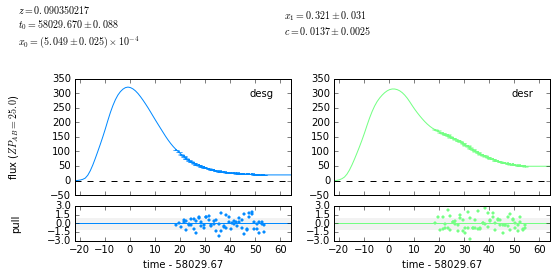

In [84]:
lc = lcs[2]
model = sncosmo.Model(source=survey.generator.lightcurve_model)
model.set(z=lc.meta['z'])
res, fitted_model = sncosmo.fit_lc(lc, model,
                                   ['t0', 'x0', 'x1', 'c'])

_ = sncosmo.plot_lc(lc, model=fitted_model, errors=res.errors)

In [57]:
model.set(z=0)
model.bandflux('besselli',-40.)

-3.3556772699924868e-18

In [58]:
model.mintime()

-20.0